## Test Single Cell

In [ ]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time
from model import MLP

device = torch.device('cpu')
dtype = torch.float32
# GJ_coupling = 'weak'
# full_seq = True

# if full_seq:
#     best_model_state_name = f"best_mlp_{GJ_coupling}_fullseq.pth"
# else:
#     best_model_state_name = f"best_mlp_{GJ_coupling}.pth"

# data_path = 'dataset/Weak_GJ_Coupling'
# hidden_dims = [128, 128, 256, 256, 128]

In [23]:
const = Constants(
            device=device,
            dtype=dtype,
            Ncell=1,
            nbeats=1,
            dt_factor=1
            )
parameters = const.parameters
# input_features = 9
# output_features = 2
# model = MLP(input_features, hidden_dims, output_features,dropout=0.1)
# model.load_state_dict(torch.load(best_model_state_name, map_location=device))
# model.to(device)
# model.eval()

In [24]:
ti = 0.0
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()

while ti < const.T:

    if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
        dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    else:
        dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2

   
    if abs(math.fmod(ti, 500)) < 1e-9:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    if abs(math.fmod(ti, dt_samp)) < 1e-8:
        phi_save.append(phi_new.clone())
    if any(torch.isnan(phi_new)):
        print('NaN detected in membrane potential!')
        break
    ti = round(ti + dt, 5) 
    # ti += dt
end = time.time()
phi_save = torch.stack(phi_save, dim=0)
print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms


KeyboardInterrupt: 

Text(0, 0.5, 'Membrane Potential (mV)')

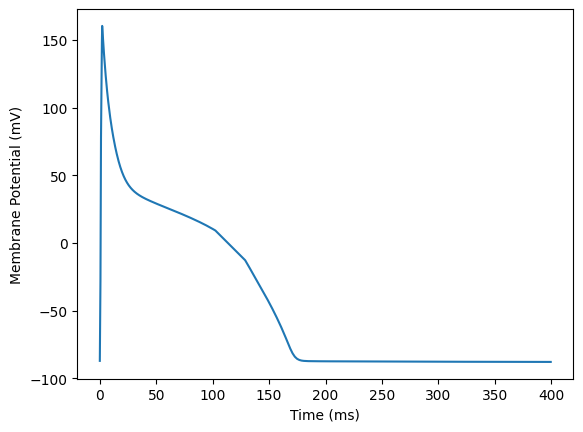

In [ ]:
import matplotlib.pyplot as plt
phi_plot = phi_save[:, 0].cpu().numpy()
ts       = const.ts
plt.plot(ts, phi_plot)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane Potential (mV)')

## Continuous Cable Equation

The 1D cable equation with ionic current is:

$$
C_m \frac{\partial V}{\partial t}
= D \frac{\partial^2 V}{\partial x^2}
- I_{\text{ion}}(t, x)
$$

### Spatial Discretization

Using a second-order central difference for the Laplacian:

$$
\frac{\partial^2 V}{\partial x^2} \Big|_i
\approx
\frac{V_{i+1}^n - 2V_i^n + V_{i-1}^n}{(\Delta x)^2}
$$

### Explicit Euler Update

$$
V_i^{n+1}
=
V_i^{n}
+
\Delta t
\left[
\frac{D}{C_m (\Delta x)^2}
\left(
V_{i+1}^n - 2V_i^n + V_{i-1}^n
\right)
-
\frac{I_{\text{ion}, i}^n}{C_m}
\right]
$$

### Matrix form

$$\mathbf{V}^n = [v_1^n,v_2^n,\cdots , v_{N-1}^n,v_N^n]^T$$

Consider Neumann B.C.
$$
\mathbf{L}_g = 
\begin{bmatrix}
-1 & 1 & 0 & \dots & 0 \\
1 & -2 & 1 & \dots & 0 \\
0 & 1 & -2 & \dots & 0 \\
\vdots & \vdots & \vdots & \ddots & 1 \\
0 & 0 & 0 & 1 & -1
\end{bmatrix}
$$

Update term,

$$
\mathbf{V}^{n+1} = \underbrace{\left( \mathbf{I} + \Delta t \frac{D}{C_m (\Delta x)^2} \mathbf{L}_g \right) }_{M}\mathbf{V}^n - \Delta t \frac{1}{C_m} \mathbf{I}_{\text{ion}}^n
$$

In [1]:
from Ionic_current.Ord11 import Ord11_model
from PermanentConstants import Constants
import torch
import math
import time

def create_diffusion_mat(N: int, dtype=torch.float32, device=None) -> torch.Tensor:
    if N < 1:
        raise ValueError("N must be at least 1.")

    diag_val = torch.full((N,), -2.0, dtype=dtype, device=device)
    diag_val[0] = -1.0
    diag_val[-1] = -1.0
    
    off_diag_val = torch.full((2 * (N - 1),), 1.0, dtype=dtype, device=device)
    
    indices_i = torch.cat([
        torch.arange(N, device=device),
        torch.arange(N - 1, device=device),
        torch.arange(N - 1, device=device) + 1
    ])
    
    indices_j = torch.cat([
        torch.arange(N, device=device),
        torch.arange(N - 1, device=device) + 1,
        torch.arange(N - 1, device=device)
    ])
    
    indices = torch.stack([indices_i, indices_j])
    values = torch.cat([diag_val, off_diag_val])
    
    return torch.sparse_coo_tensor(indices, values, (N, N), dtype=dtype, device=device)

In [2]:
# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = torch.device('cpu')
dtype = torch.float32

const = Constants(
            device=device,
            dtype=dtype,
            Ncell=100,
            nbeats=2,
            dt_factor=1
            )
parameters = const.parameters

D = 1    # Diffusion coefficient (100 μm^2/ms = 1e-3 cm^2/ms)
dx  = 125  # Grid spacing in μm (0.0125 cm)      
Ctot = parameters['Ctot']
Ncell = parameters['Ncell']
ti = 0.0
count = 0
dt = 0.01
phi_i = const.phi0.clone()
G_i   = const.g0.clone()
S     = const.S.clone()
state = torch.cat((phi_i, G_i), dim=0)
N = parameters['N']
phi_save  = []
start = time.time()
T = []

Lg = create_diffusion_mat(Ncell, dtype=dtype, device=device)
M = dt * D / (Ctot * dx**2) * Lg + torch.eye(Ncell, dtype=dtype, device=device).to_sparse()
while ti < const.T:

    # if abs(math.fmod(ti, const.parameters['bcl'])) < const.twin:
    #     dt = const.dt1; dt_samp = const.dt1_samp; Ns = const.Ns1
    # else:
    #     dt = const.dt2; dt_samp = const.dt2_samp; Ns = const.Ns2
    if dt * D / (Ctot * dx**2) > 0.5:
        raise ValueError("Stability condition violated: dt * D / (Ctot * dx^2) must be <= 0.5", dt * D / (Ctot * dx**2))
   
    if abs(math.fmod(ti, 10)) < 1e-8:
        print(f'time: {ti:.2f} ms')
    parameters['dt'] = dt

    Iion, _, G_new, dX =  Ord11_model(ti, state, parameters, S, device, dtype)

    phi_new = M @ state[0:N] + dt*(-Iion/parameters['Ctot'])
    state[0:N] = phi_new
    state[N:]  = G_new
    # phi_i = phi_new.clone()
    if abs(math.fmod(count, 10)) < 1e-8:
        phi_save.append(phi_new.clone())
        T.append(ti)
    
    if count % 1000 == 0:
        if any(torch.isnan(phi_new)):
            print('NaN detected in membrane potential!, time:', ti)
            break
    # ti = round(ti + dt, 5) 
    ti += dt
    count += 1
end = time.time()
phi_save = torch.stack(phi_save, dim=0)

print(f'Simulation time: {end - start:.2f} seconds')

time: 0.00 ms
time: 20.00 ms
time: 30.00 ms
time: 40.00 ms
time: 80.00 ms
time: 90.00 ms
time: 100.00 ms
time: 110.00 ms
time: 120.00 ms
time: 130.00 ms
time: 140.00 ms
time: 150.00 ms
Simulation time: 152.14 seconds


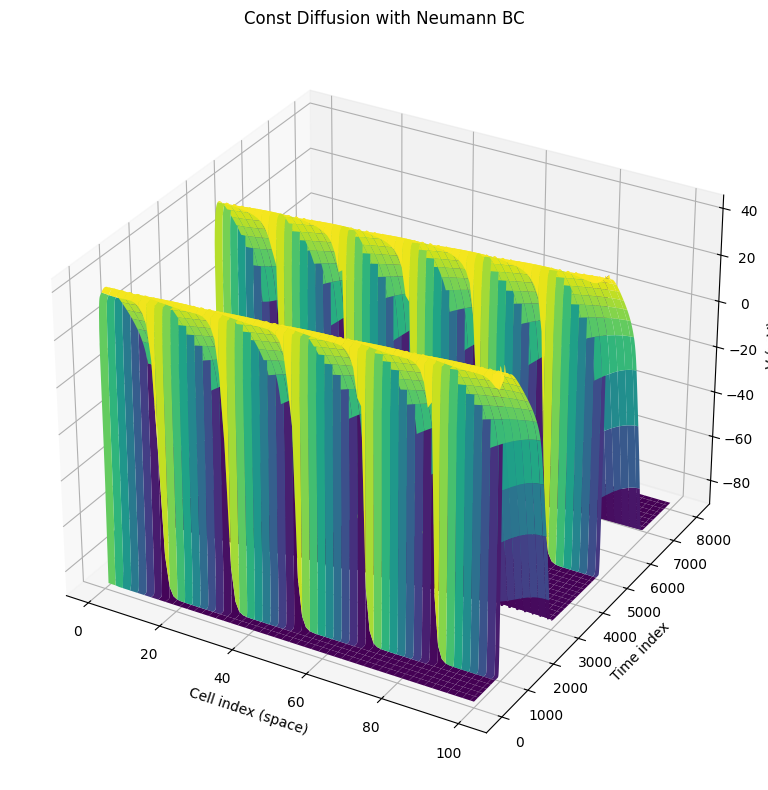

In [3]:
import matplotlib.pyplot as plt
import numpy as np

data_u = phi_save 

m, n = data_u.shape

X, Y = np.meshgrid(np.arange(1, n+1), np.arange(1, m+1))

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.plot_surface(X, Y, data_u, cmap='viridis', edgecolor='none')

ax.set_xlabel('Cell index (space)')
ax.set_ylabel('Time index')
ax.set_zlabel('V (mV)')
ax.set_title('Const Diffusion with Neumann BC')

plt.tight_layout()
plt.show()


### Test B.C.

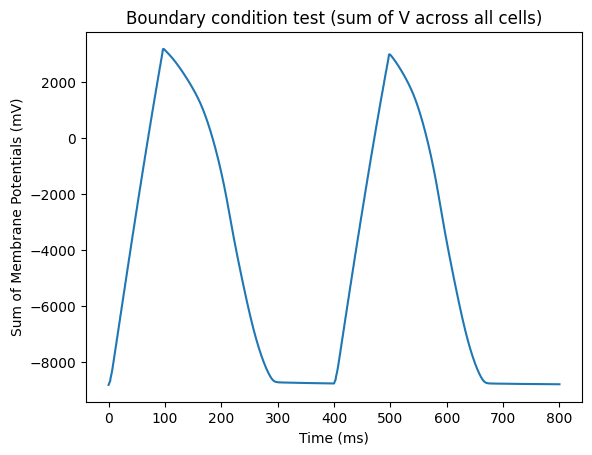

In [4]:
test = data_u.T.sum(axis=0)
t = np.array(T)
plt.plot(t, test)
plt.xlabel('Time (ms)')
plt.ylabel('Sum of Membrane Potentials (mV)')
plt.title('Boundary condition test (sum of V across all cells)')
plt.show()

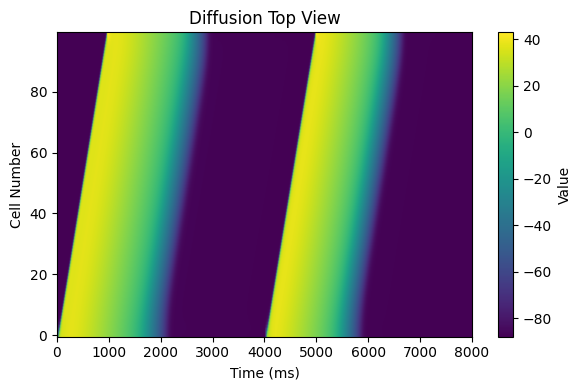

In [5]:
plt.figure(figsize=(6,4))
plt.imshow(data_u.T, 
           aspect='auto', 
           origin='lower',  
           cmap='viridis') 

plt.colorbar(label='Value')
plt.xlabel('Time (ms)')
plt.ylabel('Cell Number')
plt.title('Diffusion Top View')
plt.tight_layout()
plt.show()